In [36]:
from bs4 import BeautifulSoup
import re
import requests
import json
import pandas as pd

<h2>Parsing Salaries from Archinect.com</h2>
<p>I use beautiful soup to parse survey data on Archinect.com. The data from the survey is already structured html, so I broke parsing functions into 3 parts. The sub functions deal with parsing each part.</p>

In [37]:
def parse_details1(details_1):
    
    # Initialize with NA or default values
    firm_type = "NA"
    firm_size = "NA"
    health_insurance = "NA"
    overtime = "NA"
    vacation_days = "NA"
    annual_bonus = "NA"

    # Identify details in subcol-1
    for detail in details_1:
        if detail == "": #ignore empty strings
            continue
        elif "People" in detail:
            firm_size = detail
        elif "Health Insurance" in detail:
            health_insurance = "Yes"
        elif "Overtime" in detail:
            overtime = detail
        elif "Days Vacation" in detail:
            vacation_days = detail.replace(" Days Vacation", "")
        elif "Bonus" in detail:
            annual_bonus = detail.replace("$", "").replace(" Bonus", "")
        else:
            firm_type = detail
    return firm_type, firm_size, health_insurance, overtime, vacation_days, annual_bonus

In [38]:
# Test cases for parse_details1 function
#return format is: firm_type, firm_size, health_insurance, overtime, vacation_days, annual_bonus
test_cases = [
  (['Individual', '16-30 People', 'Health Insurance', '15 Days Vacation', '$1,000 Bonus'], ("Individual", "16-30 People", "Yes", "NA", "15", "1,000")),
  (['Boutique', '6-10 People'], ("Boutique", "6-10 People", "NA", "NA", "NA", "NA")),
  (['101-200 People'], ("NA", "101-200 People", "NA", "NA", "NA", "NA")),
   (['No Overtime'], ("NA", "NA", "NA", "No Overtime", "NA", "NA")),
   (['Corporate', '31-50 People', 'Health Insurance', 'Unpaid Overtime', '15 Days Vacation', '$10,000 Bonus'], ("Corporate", "31-50 People", "Yes", "Unpaid Overtime", "15", "10,000")),
]

# Run test cases
for i, (input_data, expected_output) in enumerate(test_cases):
  result = parse_details1(input_data)
  assert result == expected_output, f"Test case {i+1} failed: expected {expected_output}, got {result}"
print("All test cases passed!")


All test cases passed!


In [39]:
def parse_details2(details_2):
  # Initialize with NA or default values
  work_status = "NA"
  years_of_experience = "NA"
  age = "NA"
  gender = "NA"
  licensed = "No"

  # Identify details in subcol-2
  for detail in details_2:
      if detail == "": #ignore empty strings
        continue
      elif "time" in detail:
          work_status = detail
      elif "Freelance" in detail:
          work_status = detail
      elif "Years of Experience" in detail:
          #if detail is < 1 Years of Experience then
            if "<" in detail:
                years_of_experience = "< 1"
            else:
                years_of_experience = detail.split()[0]  # Assuming the first part is the number
      elif "Years old" in detail:
          age = detail.split()[0]  # Assuming the first part is the number 
      elif "Licensed" in detail:
          licensed = "Licensed"
      else:
          gender = detail

  return work_status, years_of_experience, age, gender, licensed


In [40]:
# Test cases for parse_details2 function
test_cases_parse_details2 = [
  (['Full-time', '3-5 Years of Experience', '26-30 Years old', 'Male', 'Licensed'], ("Full-time", "3-5", "26-30", "Male", "Licensed")),
  (['Full-time', '2 Years of Experience', '21-25 Years old', 'Female'], ("Full-time", "2", "21-25", "Female", "No")),
  (['', '3-5 Years of Experience', '21-25 Years old', 'Male'], ("NA", "3-5", "21-25", "Male", "No")),
  (['Part-time', '8-10 Years of Experience', '26-30 Years old', 'Female'], ("Part-time", "8-10", "26-30", "Female", "No")),
  (['Freelance', '11-15 Years of Experience', '46-50 Years old', 'Male', 'Licensed'], ("Freelance", "11-15", "46-50", "Male", "Licensed")),
  (['Full-time', '6-7 Years of Experience', '26-30 Years old', 'Male'], ("Full-time", "6-7", "26-30", "Male", "No")),
  (['Full-time', '3-5 Years of Experience', '26-30 Years old', 'Gender: Other'], ("Full-time", "3-5", "26-30", "Gender: Other", "No")),
  (['Full-time', '3-5 Years of Experience', '26-30 Years old', 'Female'], ("Full-time", "3-5", "26-30", "Female", "No")),
  (['Full-time', '< 1 Years of Experience', '21-25 Years old', 'Female'], ("Full-time", "< 1", "21-25", "Female", "No")),
  (['Full-time', '26-30 Years of Experience', '51-55 Years old', 'Male', 'Licensed'], ("Full-time", "26-30", "51-55", "Male", "Licensed"))
]

# Run test cases
for i, (input_data, expected_output) in enumerate(test_cases_parse_details2):
  result = parse_details2(input_data)
  assert result == expected_output, f"Test case {i+1} failed: expected {expected_output}, got {result}"
print("All test cases for parse_details2 passed!")

All test cases for parse_details2 passed!


In [41]:
def parse_entry(entry):
    id=entry[0]
    soup = BeautifulSoup(entry[1], 'html.parser')

    # Extract job satisfaction (from img tag)
    job_satisfaction_img = soup.find('img', class_='emoticon')
    if job_satisfaction_img and job_satisfaction_img.has_attr('data-original-title'):
        job_satisfaction = job_satisfaction_img['data-original-title'].split(': ')[1]
    else:
        job_satisfaction = "NA"

    # Extract salary, location, and job title (from h3 tag)
    h3 = soup.find('h3')
    if h3:
        # Extract salary
        salary_tag = h3.find('span', class_='salary')
        #this is either $x per hour or $ per year, parse as is
        
        salary = re.sub(r'[^0-9,]', '', salary_tag.text) if salary_tag else "NA"
        salary_unit = re.sub(r'[^a-zA-Z]', '', salary_tag.text) if salary_tag else "NA"

        # Extract location
        location_tag = h3.find_next('span', class_='slash').next_sibling if h3.find('span', class_='slash') else ""
        location = location_tag.strip() if location_tag else "NA"

        # Extract job title
        job_title_tag = h3.find_all('span', class_='slash')[-1].next_sibling if h3.find_all('span', class_='slash') else ""
        job_title = job_title_tag.strip() if job_title_tag else "NA"
    else:
        salary = location = job_title = "NA"

    # Extract details from subcol-1
    subcol_1 = soup.find('ul', class_='subcol-1')
    details_1 = [li.get_text(strip=True) for li in subcol_1.find_all('li')] if subcol_1 else []
    firm_type, firm_size, health_insurance, overtime, vacation_days, annual_bonus = parse_details1(details_1)
    
    # Extract details from subcol-2
    subcol_2 = soup.find('ul', class_='subcol-2')
    details_2 = [li.get_text(strip=True) for li in subcol_2.find_all('li')] if subcol_2 else []
    work_status, years_of_experience, age, gender, licensed = parse_details2(details_2)


    # Extract details from subcol-3
    subcol_3 = soup.find('ul', class_='subcol-3')
    details_3 = [li.get_text(strip=True) for li in subcol_3.find_all('li')] if subcol_3 else []
    undergraduate_school = next((x.replace("UG: ", "").strip() for x in details_3 if x.startswith("UG:")), "NA")
    graduate_school = next((x.replace("Grad: ", "").strip() for x in details_3 if x.startswith("Grad:")), "NA")
    post_graduate_school = next((x.replace("PhD: ", "").strip() for x in details_3 if x.startswith("PhD:")), "NA")

    # Extract date stamp
    date_stamp = soup.find('div', class_='date-stamp')
    date = date_stamp.get_text(strip=True) if date_stamp else "NA"

    # Construct the JSON structure
    result = {
        "id": id,
        "Job Satisfaction": job_satisfaction,
        "Salary": salary,
        "Salary Unit": salary_unit,
        "Location": location,
        "Job Title": job_title,
        "Firm Type": firm_type,
        "Firm Size": firm_size,
        "Health Insurance": health_insurance,
        "Overtime": overtime,
        "Vacation Days": vacation_days,
        "Annual Bonus": annual_bonus,
        "Work Status": work_status,
        "Years of Experience": years_of_experience,
        "Age": age,
        "Gender": gender,
        "Licensed": licensed,
        "Undergraduate School": undergraduate_school,
        "Graduate School": graduate_school,
        "Post-Graduate School": post_graduate_school,
        "Date": date
    }

    return result


In [42]:
def query_data():
    url = "https://salaries.archinect.com/salarypoll/results" #this is the url to query
    params = {
        'sEcho': '2',
        'iColumns': '2',
        'sColumns': '',
        'iDisplayStart': '0',
        'iDisplayLength': '15000', #set max entries to parse
        'mDataProp_0': '0',
        'mDataProp_1': '1',
        'sSearch': '',
        'bRegex': 'false',
        'sSearch_0': '',
        'bRegex_0': 'false',
        'bSearchable_0': 'false',
        'sSearch_1': '',
        'bRegex_1': 'false',
        'bSearchable_1': 'true',
        'iSortCol_0': '0',
        'sSortDir_0': 'asc',
        'iSortingCols': '1',
        'bSortable_0': 'true',
        'bSortable_1': 'false',
        'age': '[]',
        'gender': '[]',
        'job_title': '[]',
        'primary_market': '[]',
        'experience': '[]',
        'firm_type': '[]',
        'firm_size': '[]',
        'work_status': '[]',
        'license': '[]',
        'health_insurance': '[]',
        'overtime': '[]',
        'annual_bonus': '[]',
        'sort_by': 'id',
        'salary-range': '0;10000000',
        'range_plus': 'true',
        'location': 'United States',
        'under_graduate_school': '',
        'graduate_school': '',
        'post_graduate_school': '',
        'location_type': 'country',
        'salary_time': '[]',
        'job_satisfaction': '[]',
        '_': '1728972672843'
    }

    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3',
        'X-Requested-With': 'XMLHttpRequest'
    }

    # Make the request
    response = requests.get(url, params=params, headers=headers)

    parsed_data=[]

    if response.status_code == 200:
        try:
            # Parse the JSON response
            json_data = response.json()
            
            for entry in json_data['aaData']:
                if entry[0] != "":  # Filter out entries with empty first elements
                    parsed_entry = parse_entry(entry)
                    parsed_data.append(parsed_entry)

            # Convert the list of dictionaries into a pandas DataFrame
            df = pd.DataFrame(parsed_data)
            return df
        except json.JSONDecodeError:
            print("Failed to decode JSON")
    else:
        print(f"Failed to retrieve data. Status code: {response.status_code}")

<h4>Uncomment the two lines below to query data and save to csv. </h4>
<p>This can take a bit depending on your internet speed and device specs, so if you just want to analyze data please just read data from the pre-run csv.

In [43]:
#uncomment to requery data, otherwise just use read_csv from 
#this takes about 30 seconds on my computer
# df = query_data()
# df.to_csv("archinect_salaries_raw.csv", index=False)

In [44]:
#read data, last updated 250306
df = pd.read_csv("archinect_salaries_raw.csv")

In [45]:
df['Date']

0        Mar '25
1        Mar '25
2        Mar '25
3        Mar '25
4        Mar '25
          ...   
14995    Apr '13
14996    Apr '13
14997    Apr '13
14998    Apr '13
14999    Apr '13
Name: Date, Length: 15000, dtype: object

<h3>Data cleaning</h3>
<p>Setting correct units, deleting outliers, focusing on US and full-time workers</p>

In [46]:
#remove the prefixes in Undergraduate Schools and Graduate Schools
df['Undergraduate School'] = df['Undergraduate School'].str.replace('UG:', '')
df['Graduate School'] = df['Graduate School'].str.replace('Grad:', '')
df['Post-Graduate School'] = df['Post-Graduate School'].str.replace('PhD:', '')

#remove per from salary type (perhour becomes hour, peryear becomes year)
df['Salary Unit'] = df['Salary Unit'].str.replace('per', '')

#remove Gender from gender (Gender: Other becomes Other)
df['Gender'] = df['Gender'].str.replace('Gender: ', '')

#Licensed values changed to either Yes or No
df["Licensed"] = df["Licensed"].str.replace('Licensed', 'Yes')

#replace 40 in "Years of Experience" with 40+
df['Years of Experience'] = df['Years of Experience'].replace({
            '31- >40': '30-40',   # Replace exact match of '31- >40' to '30-40'
            '40': '> 40'           # Replace exact match of '40' to '>40'
        })

#drop the individuals over 103 age because they seem to be spam inputs
df = df[df['Age']!="103"]

#this entry represents a 18-20 year old earning 200,000+ per HOUR, definitely wrong
df = df[df['id']!=12734]

#this represents a 18-20 year old earning 355 per HOUR as the CEO of a 500+ people firm, definitely wrong
df = df[df['id']!=2653]

In [47]:
#univeristy of hawaii at manoa is misspelled in the data
df['Undergraduate School'] = df['Undergraduate School'].str.replace('University of Hawai.i at M.noa', 'University of Hawaiʻi at Mānoa', regex = True)
df['Graduate School'] = df['Graduate School'].str.replace('University of Hawai.i at M.noa', 'University of Hawaiʻi at Mānoa', regex = True)
df['Post-Graduate School'] = df['Post-Graduate School'].str.replace('University of Hawai.i at M.noa', 'University of Hawaiʻi at Mānoa', regex = True)

In [48]:
#we have a total of 14633 entries (this is not fixed, expect higher number as more entries are added)
df.shape

(14996, 21)

In [49]:
#examine the duplicates, this is probably due to people clicking submit multiple times
duplicates = df[df.duplicated(subset=df.columns.difference(['id']), keep=False)]

#remove the duplicates
df.drop_duplicates(subset=df.columns.difference(['id']), keep='first', inplace=True)

In [50]:
# noticed some weird inputs, investigating
criteria = df["Post-Graduate School"].notna() & (df['Date'] == "Jun '24") & (df['Location'] == "Austin, TX, US")

#this seems like bad data, delete all that meet this criteria
#df[criteria] (uncomment to see)

# Drop the rows that match the criteria
df.drop(df[criteria].index, inplace=True)

In [51]:
#remove ' character from Date, and extract year
df['Date'] = df['Date'].str.replace("'", "")

df['Date']  = pd.to_datetime(df['Date'], format='%b %y')
df['Year'] = df['Date'].dt.year

In [52]:
#currently all values are in strings, I want to convert the numerical values to integers, and have NA be pandas NaN

assert ((df['Salary']=="NA").sum() ==0) #salary doesn't have any NA values, 
df['Salary'] = df['Salary'].str.replace(',', '').astype(int)


In [53]:
assert ((df['Job Satisfaction']=="NA").sum() ==0)
#try to convert Job Satisfaction to int, if fails then put NaN
df['Job Satisfaction'] = pd.to_numeric(df['Job Satisfaction'], errors='coerce')

#set Job Satisfaction to be a categorical feature
df['Job Satisfaction'] = df['Job Satisfaction'].astype(int)

df = df[df['Job Satisfaction'].notna()]

In [54]:
#when I did this 56 duplicates were removed
df.shape

(14905, 22)

In [55]:
#save a copy just in case
df_old=df.copy()

In [56]:
#check type of all columns
print("full time: ", df[df['Work Status']=='Full-time'].shape[0])
print("part time: ", df[df['Work Status']=="Part-time"].shape[0])
print("freelance: ", df[df['Work Status']=="Freelance"].shape[0])
print("not specified: ", df[df['Work Status'].isna()].shape[0])

full time:  12639
part time:  297
freelance:  214
not specified:  1755


<p>To preserve as much data as possible, I convert individuals working fulltime and freelance with hourly income to yearly income by multiplying it by 40*52 hours a year. If you want to be more precise feel free to drop those in entirety. I drop part-time individuals.</p>

In [57]:
#convert the hourly income to annual income if working full time
df_fulltime = df[df['Work Status']!="Part-time"].copy()

#TODO: should the hourly rate be extrapolated or just dropped?
#df_fulltime[(df_fulltime["Salary Unit"] == "hour") & (df_fulltime["Salary"]>100000)]
df_fulltime["Salary"] = df_fulltime.apply(lambda x: x['Salary']*40*52 if x['Salary Unit']=="hour" and x['Work Status']=="Full-time" else x['Salary'], axis=1)


#get rid of entries with annual income less than $10,000 (this is probably people who work much less than 40*52 hours a year)
df_fulltime = df_fulltime[df_fulltime["Salary"]>=10000]

<p>I used the Nominatim package to find latitude and longitude for all locations in the surveys. No need to rerun for all locations, I've saved all locations that were a part of the surveys before October 2024 in location_coordinates.csv. Just need to rerun for those that are not apart of that.</p>

In [58]:
!pip install geopy
from geopy.geocoders import Nominatim

# Initialize the geolocator
geolocator = Nominatim(user_agent="architects_locations")

# Function to get coordinates
def get_coordinates(location):
  try:
    loc = geolocator.geocode(location)
    if loc:
      print(f"Location: {location}, Latitude: {loc.latitude}, Longitude: {loc.longitude}")
      return (loc.latitude, loc.longitude)
    else:
      print(f"Location: {location}, Latitude: None, Longitude: None")
      return (None, None)
  except:
    return (None, None)

# # Get unique locations
# unique_locations = df_fulltime['Location'].unique()

# # Create a dictionary to store the coordinates for each unique location
# location_coordinates = {location: get_coordinates(location) for location in unique_locations}

# # Create new columns for latitude and longitude in the original DataFrame
# df_fulltime['Latitude'] = df_fulltime['Location'].map(lambda x: location_coordinates[x][0])
# df_fulltime['Longitude'] = df_fulltime['Location'].map(lambda x: location_coordinates[x][1])

# import csv

# # Define the CSV file name
# csv_file = "location_coordinates.csv"

# # Write the dictionary to a CSV file
# with open(csv_file, mode='w', newline='') as file:
#   writer = csv.writer(file)
#   writer.writerow(["Location", "Latitude", "Longitude"])  # Write the header
#   for location, coordinates in location_coordinates.items():
#     writer.writerow([location, coordinates[0], coordinates[1]])  # Write the data


In [59]:
# Read the location coordinates from the CSV file
location_df = pd.read_csv("location_coordinates.csv")

# Merge the location coordinates with the main DataFrame
df_fulltime = df_fulltime.merge(location_df, on="Location", how="left")

#drop the columns that are not needed
#df_fulltime.drop(columns=["id", "Salary Unit"], inplace=True)

#replace " People" with "" in Firm Size
df_fulltime['Firm Size'] = df_fulltime['Firm Size'].str.replace(" People", "")
df_fulltime['Firm Size'] = df_fulltime['Firm Size'].str.replace("501 +", "501+")

In [60]:
# Get new unique locations
new_unique_locations = df_fulltime[df_fulltime['Latitude'].isna()]['Location'].unique()

# Create a dictionary to store the coordinates for each unique location
new_location_coordinates = {location: get_coordinates(location) for location in new_unique_locations}

# Create new columns for latitude and longitude in the original DataFrame
# Update the DataFrame with new coordinates
df_fulltime['Latitude'] = df_fulltime.apply(lambda x: new_location_coordinates[x['Location']][0] if pd.isna(x['Latitude']) else x['Latitude'], axis=1)
df_fulltime['Longitude'] = df_fulltime.apply(lambda x: new_location_coordinates[x['Location']][1] if pd.isna(x['Longitude']) else x['Longitude'], axis=1)


Location: El Segundo, CA, US, Latitude: 33.917028, Longitude: -118.4156337
Location: Larchmont, NY, US, Latitude: 40.9278769, Longitude: -73.7517983
Location: Columbia, MD, US, Latitude: 39.1938429, Longitude: -76.86460919353361
Location: Takoma Park, MD, US, Latitude: 38.9778882, Longitude: -77.0074765
Location: Chinatown, CA, US, Latitude: 37.7943011, Longitude: -122.4063757
Location: Chesterfield, MO, US, Latitude: 38.661953, Longitude: -90.5643258
Location: Statesborough, GA, US, Latitude: 32.2176935, Longitude: -81.7237232
Location: Cusseta, AL, US, Latitude: 32.7848521, Longitude: -85.3057779
Location: Newnan, GA, US, Latitude: 33.3806716, Longitude: -84.7996573
Location: Cedar Falls, IA, US, Latitude: 42.5361805, Longitude: -92.447758
Location: Cedar Grove, NJ, US, Latitude: 40.8517662, Longitude: -74.229035
Location: Fontana, CA, US, Latitude: 34.0922947, Longitude: -117.43433
Location: Steamboat Springs, CO, US, Latitude: 40.4848003, Longitude: -106.831735
Location: South Lake

In [63]:
#make sure that there are no more missing latitude and longitude values
#note: there might be still be missing locations if Nominatim can't find the location
#sadly, these require manual intervention. I manually input around 5 locations for the 13,000+ entries
#you should input these locations with lat long in location_coordinates.csv
#or, you can uncomment the line below to drop those items altogether
#df_fulltime.dropna(subset=['Latitude'], inplace=True)
assert len(df_fulltime[df_fulltime['Latitude'].isna()]) == 0

In [64]:
#then drop the US in locations because otherwise very repetitive
df_fulltime['Location']=df_fulltime['Location'].str.replace(", US", "")

In [65]:
df_fulltime.columns

Index(['id', 'Job Satisfaction', 'Salary', 'Salary Unit', 'Location',
       'Job Title', 'Firm Type', 'Firm Size', 'Health Insurance', 'Overtime',
       'Vacation Days', 'Annual Bonus', 'Work Status', 'Years of Experience',
       'Age', 'Gender', 'Licensed', 'Undergraduate School', 'Graduate School',
       'Post-Graduate School', 'Date', 'Year', 'Latitude', 'Longitude'],
      dtype='object')

<h4>Initial analysis and cleaning</h4>
<p>After limiting data to just fulltime workers, I take a closer look at the entries and get rid of more "bad" data.</p>

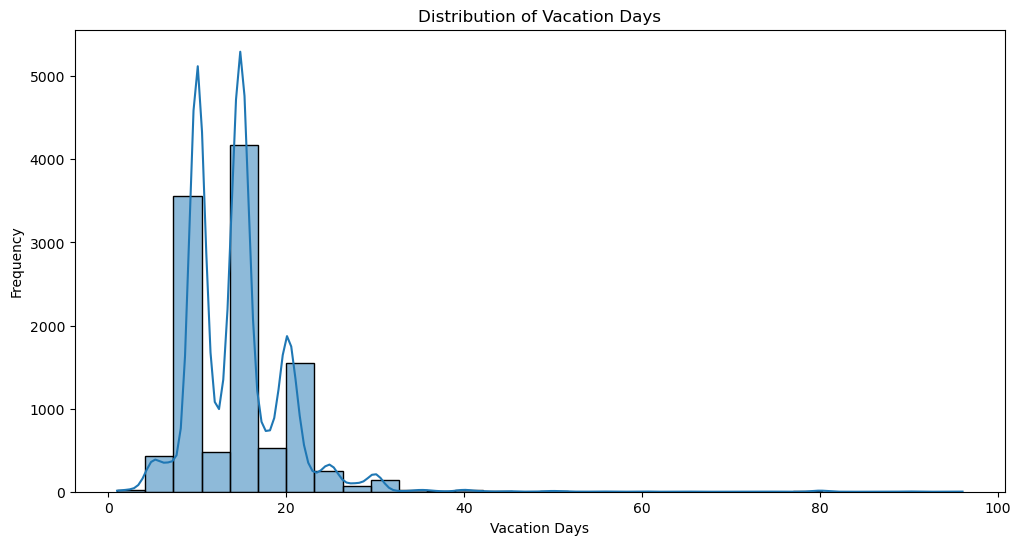

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

# df_fulltime[df_fulltime["Vacation Days"]>100]
plt.figure(figsize=(12, 6))
sns.histplot(df_fulltime[df_fulltime["Vacation Days"]<100]["Vacation Days"].dropna(), bins=30, kde=True)
plt.title("Distribution of Vacation Days")
plt.xlabel("Vacation Days")
plt.ylabel("Frequency")
plt.show()

In [67]:
# To get the rows where "Annual Bonus" has things other than numbers and commas
notnarows = df_fulltime[df_fulltime["Annual Bonus"].notna()]
invalid_bonus_rows = notnarows[notnarows["Annual Bonus"].str.contains(r'[^0-9,]', regex=True)]
invalid_bonus_rows["Annual Bonus"]

2558     CAD8,000
8053      ¥42,000
10284      €8,460
10971     €25,000
11527      €2,000
Name: Annual Bonus, dtype: object

In [68]:
#shanghai and stuggart are obviously wrong, so remove ids 5573 and 4576 from df_fulltime
df_fulltime = df_fulltime[df_fulltime['id']!=5573]
df_fulltime = df_fulltime[df_fulltime['id']!=8747]

#do a conversion for the canadian using 1 CAD = 0.72 USD, rewrite id 17103's salary as salary*0.72
df_fulltime.loc[df_fulltime['id']==17102, 'Salary'] = round(105000*0.72)
df_fulltime.loc[df_fulltime['id']==17102, 'Salary Unit'] = "year"
df_fulltime.loc[df_fulltime['id']==17102, 'Annual Bonus'] = str(round(8000*0.72))

#conversion from 1 EUR to 1.08 USD
df_fulltime.loc[df_fulltime['id']==4576, 'Annual Bonus'] = str(round(25000*1.08))
df_fulltime.loc[df_fulltime['id']==3825, 'Annual Bonus'] = str(round(2000*1.08))

In [69]:
#convert annual bonus to numbers
df_fulltime["Annual Bonus"] = df_fulltime["Annual Bonus"].str.replace(r'[^0-9]', '', regex=True).astype(float)

In [70]:
#The annual bonus also revealed some funky salary units, so I will correct these
df_fulltime["Salary Unit"].unique()

array(['year', 'hour', 'CADyear', 'localcurrencyyear', 'CHFyear'],
      dtype=object)

In [71]:
#correct the CAD
df_fulltime.loc[df_fulltime['Salary Unit']=="CADyear",'Salary Unit'] = "year"
df_fulltime.loc[df_fulltime['Salary Unit']=="CADyear",'Salary'] = round(df_fulltime.loc[df_fulltime['Salary Unit']=="CADyear",'Salary']*0.72)

In [72]:
#local currency seems to be just usd, so change it to year
df_fulltime.loc[df_fulltime['Salary Unit']=="localcurrencyyear",'Salary Unit'] = "year"

In [73]:
#the salary unit of CHF is in Switzerland, so this is a bad entry, I delete it
print(df_fulltime.loc[df_fulltime['Salary Unit']=="CHFyear"])
df_fulltime = df_fulltime[df_fulltime['id']!=3616]

         id  Job Satisfaction  Salary Salary Unit       Location Job Title  \
11624  3616                 7   24000     CHFyear  Neuchatel, KS    Intern   

        Firm Type Firm Size Health Insurance       Overtime  ...    Age  \
11624  Individual       2-5              NaN  Paid Overtime  ...  26-30   

       Gender Licensed Undergraduate School Graduate School  \
11624  Female      Yes      CEPT University      ETH Zürich   

      Post-Graduate School       Date  Year   Latitude  Longitude  
11624                  NaN 2013-10-01  2013  39.568052 -96.201946  

[1 rows x 24 columns]


In [74]:
#Now the units should only be year and hour (hour kept to refer to those that were converted to annual)
df_fulltime["Salary Unit"].unique()

array(['year', 'hour'], dtype=object)

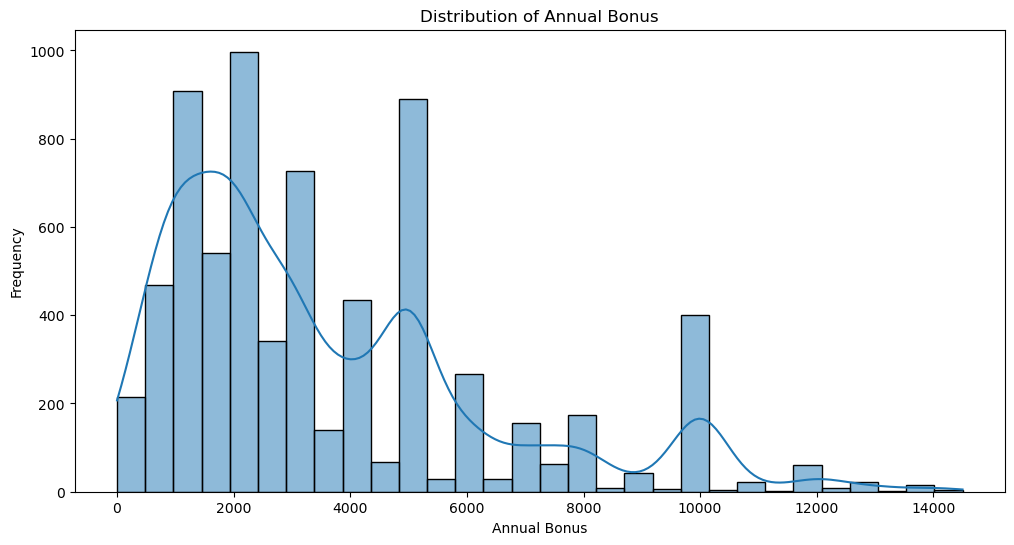

In [75]:

plt.figure(figsize=(12, 6))
sns.histplot(df_fulltime[df_fulltime["Annual Bonus"]<15000]["Annual Bonus"].dropna(), bins=30, kde=True)
plt.title("Distribution of Annual Bonus")
plt.xlabel("Annual Bonus")
plt.ylabel("Frequency")
plt.show()

<h4>Inflation Adjusted Income</h4>

To adjust past income to today's standards, I calculate inflation rate by dividing current Consumer Price Index (CPI) by the CPI when the survey was taken. I used the average CPI data for US cities found [here](https://fred.stlouisfed.org/series/CPIAUCSL).

In [78]:
df_cpi = pd.read_csv("CPIAUCSL.csv")

#convert Date to datetime object
df_cpi["DATE"] = pd.to_datetime(df_cpi["DATE"])

#this information only goes to 2025/01, so for months after I'll substitute the latest data available
new_row = pd.DataFrame({'DATE': [pd.Timestamp('2025-03-01')], 'CPIAUCSL': [df_cpi[df_cpi['DATE'] == '2025-01-01']['CPIAUCSL'].values[0]]})
new_row2 = pd.DataFrame({'DATE': [pd.Timestamp('2025-02-01')], 'CPIAUCSL': [df_cpi[df_cpi['DATE'] == '2025-01-01']['CPIAUCSL'].values[0]]})
df_cpi = pd.concat([df_cpi, new_row], ignore_index=True)
df_cpi = pd.concat([df_cpi, new_row2], ignore_index=True)

In [79]:
#merge cpi onto df_fulltime
df_fulltime = pd.merge(df_fulltime, df_cpi, left_on='Date', right_on='DATE', how='left')
df_fulltime.drop(columns=['DATE'], inplace=True)

#check to see if there are any missing values
df_fulltime['CPIAUCSL'].isna().sum()

0

In [80]:
#calculate inflation-adjusted salary
#we just take the last row of CPIAUCSL as the current value (2024/11 which is the same as 2024/10)
current_cpi = df_cpi.iloc[-1]['CPIAUCSL']
df_fulltime['Inflation Adjusted Salary'] = df_fulltime['Salary'] * (current_cpi/df_fulltime['CPIAUCSL'])

<h4>Export to csv, this is used for d3.js</h4>

In [ ]:
#241114(before official site launch) had 13838 entries
#241123 (2 days after launch) has 13855 entries
#241209 (2 weeks after launch), archinect poll has 13888 entries
#250306, archinect poll has 14157 entries
df_fulltime.shape

(14157, 26)

In [82]:
#round the inflation adjusted salary to the nearest 100
df_fulltime['Inflation Adjusted Salary'] = df_fulltime['Inflation Adjusted Salary'].round(-2)

In [83]:
df_fulltime.to_csv("archinect_salaries_fulltime.csv", index=False)